# Library import

In [1]:
# 필요 library들을 import합니다.
import os
from typing import Tuple, Any, Callable, List, Optional, Union

import cv2
import timm
import torch
import numpy as np
import pandas as pd
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from functions.functions import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Training

In [2]:
# 학습에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 학습 데이터의 경로와 정보를 가진 파일의 경로를 설정.
traindata_dir = "./data/canny"    # "./data/train"
traindata_info_file = "./data/train.csv"
save_result_path = "./train_result"

In [4]:
cd ..

/data/ephemeral/home/cv20-proj1/level1-imageclassification-cv-20/suyoung


In [5]:
# 학습 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
train_info = pd.read_csv(traindata_info_file)

# 총 class의 수를 측정.
num_classes = len(train_info['target'].unique())

# 각 class별로 8:2의 비율이 되도록 학습과 검증 데이터를 분리.
train_df, val_df = train_test_split(
    train_info, 
    test_size=0.2,
    stratify=train_info['target']
)

In [6]:
# 학습에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "torchvision"
)
train_transform = transform_selector.get_transform(is_train=True)
val_transform = transform_selector.get_transform(is_train=False)

# 학습에 사용할 Dataset을 선언.
train_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=train_df,
    transform=train_transform
)
val_dataset = CustomDataset(
    root_dir=traindata_dir,
    info_df=val_df,
    transform=val_transform
)

# 학습에 사용할 DataLoader를 선언.
train_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=128, 
    shuffle=False
)

In [7]:
# 학습에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet101', 
    pretrained=True
)
model = model_selector.get_model()

# 선언된 모델을 학습에 사용할 장비로 셋팅.
model.to(device)

TimmModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [8]:
# 학습에 사용할 optimizer를 선언하고, learning rate를 지정
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.001
)

In [9]:
# 스케줄러 초기화
scheduler_step_size = 30  # 매 30step마다 학습률 감소
scheduler_gamma = 0.1  # 학습률을 현재의 10%로 감소

# 한 epoch당 step 수 계산
steps_per_epoch = len(train_loader)

# 2 epoch마다 학습률을 감소시키는 스케줄러 선언
epochs_per_lr_decay = 2
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step_size, 
    gamma=scheduler_gamma
)

In [10]:
# 학습에 사용할 Loss를 선언.
loss_fn = Loss()

In [11]:
# 앞서 선언한 필요 class와 변수들을 조합해, 학습을 진행할 Trainer를 선언. 
trainer = Trainer(
    model=model, 
    device=device, 
    train_loader=train_loader,
    val_loader=val_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn, 
    epochs=100,
    result_path=save_result_path
)

Epoch 1/100


Epoch 1, Train Loss: 5.0051, Train Accuracy: 0.1342
Epoch 1, Validation Loss: 2.6150, Validation Accuracy: 0.3907

Save 0epoch result. Loss = 2.6150
Lowest loss updated to 2.6150. Early stop counter reset to 0.


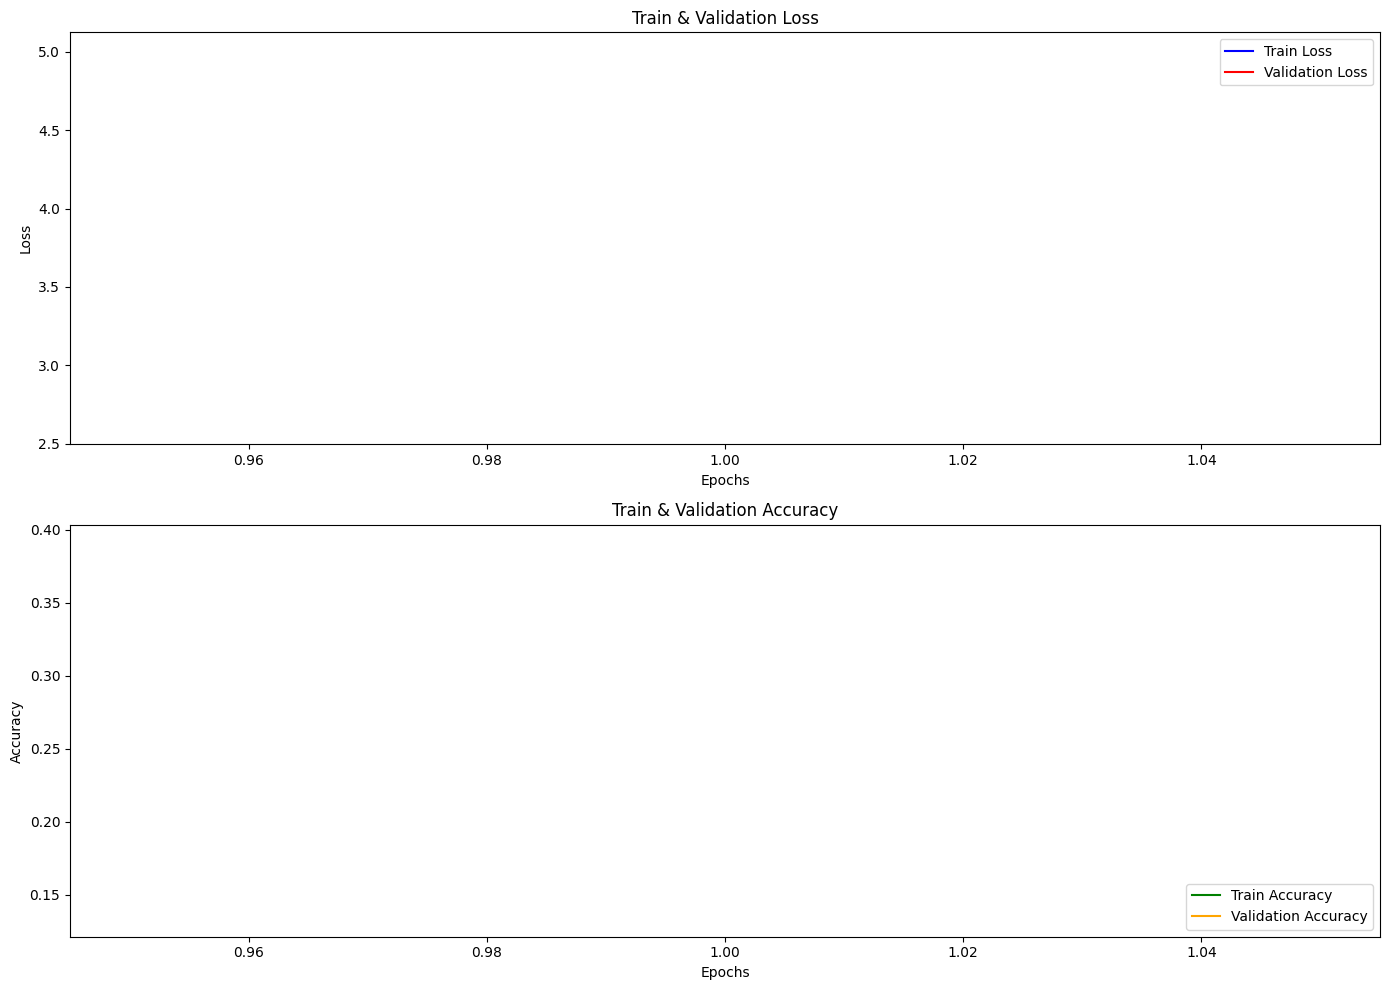

Epoch 2/100


Epoch 2, Train Loss: 1.6932, Train Accuracy: 0.5682
Epoch 2, Validation Loss: 1.5307, Validation Accuracy: 0.6123

Save 1epoch result. Loss = 1.5307
Lowest loss updated to 1.5307. Early stop counter reset to 0.


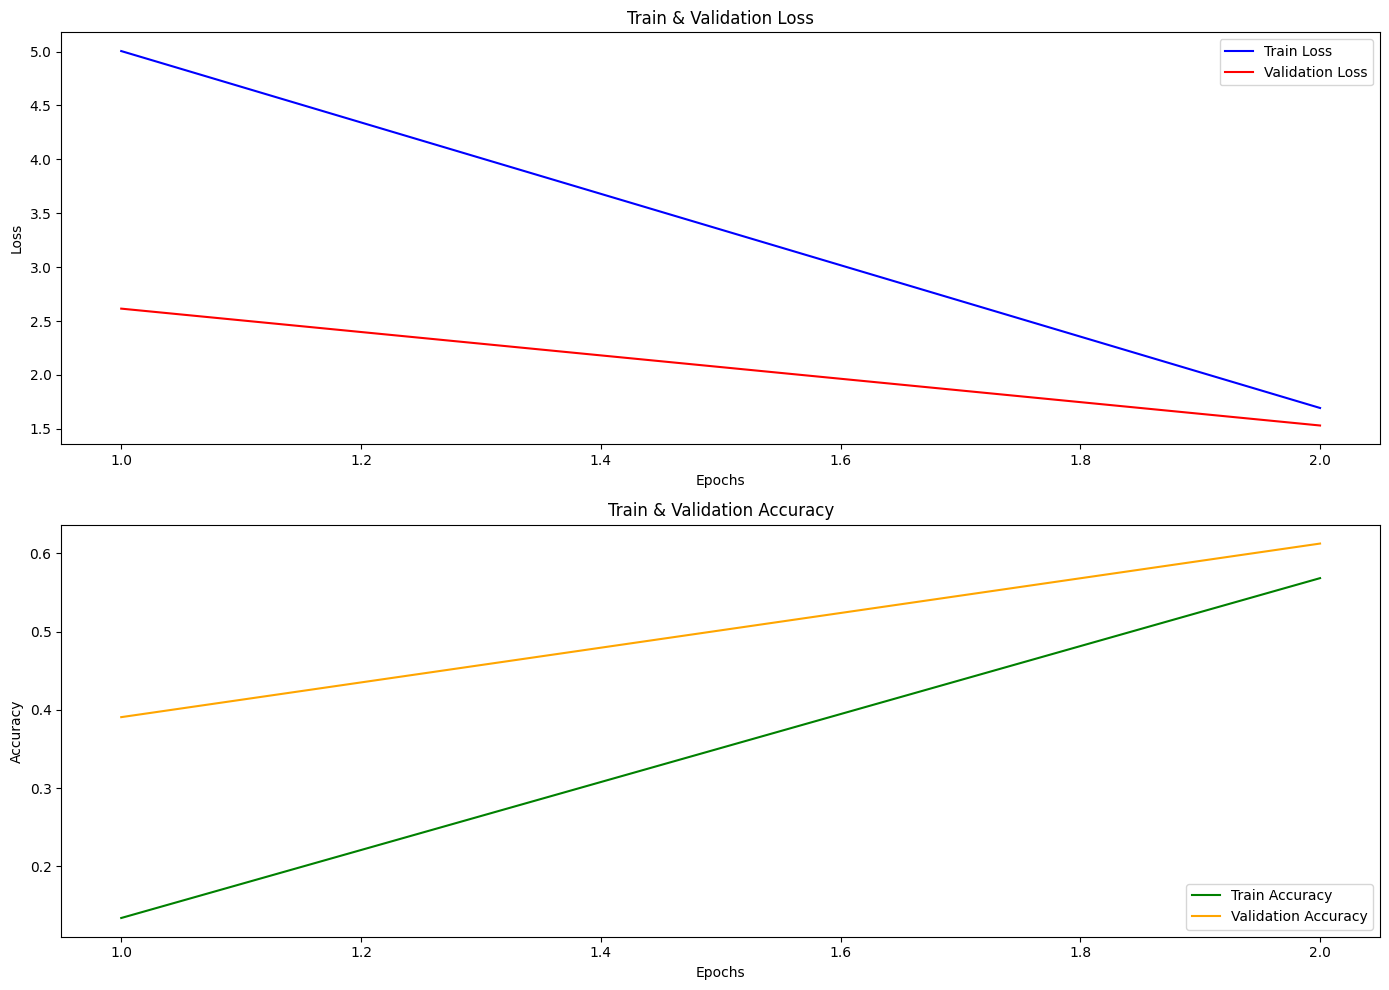

Epoch 3/100


Epoch 3, Train Loss: 0.8861, Train Accuracy: 0.7494
Epoch 3, Validation Loss: 1.2829, Validation Accuracy: 0.6666

Save 2epoch result. Loss = 1.2829
Lowest loss updated to 1.2829. Early stop counter reset to 0.


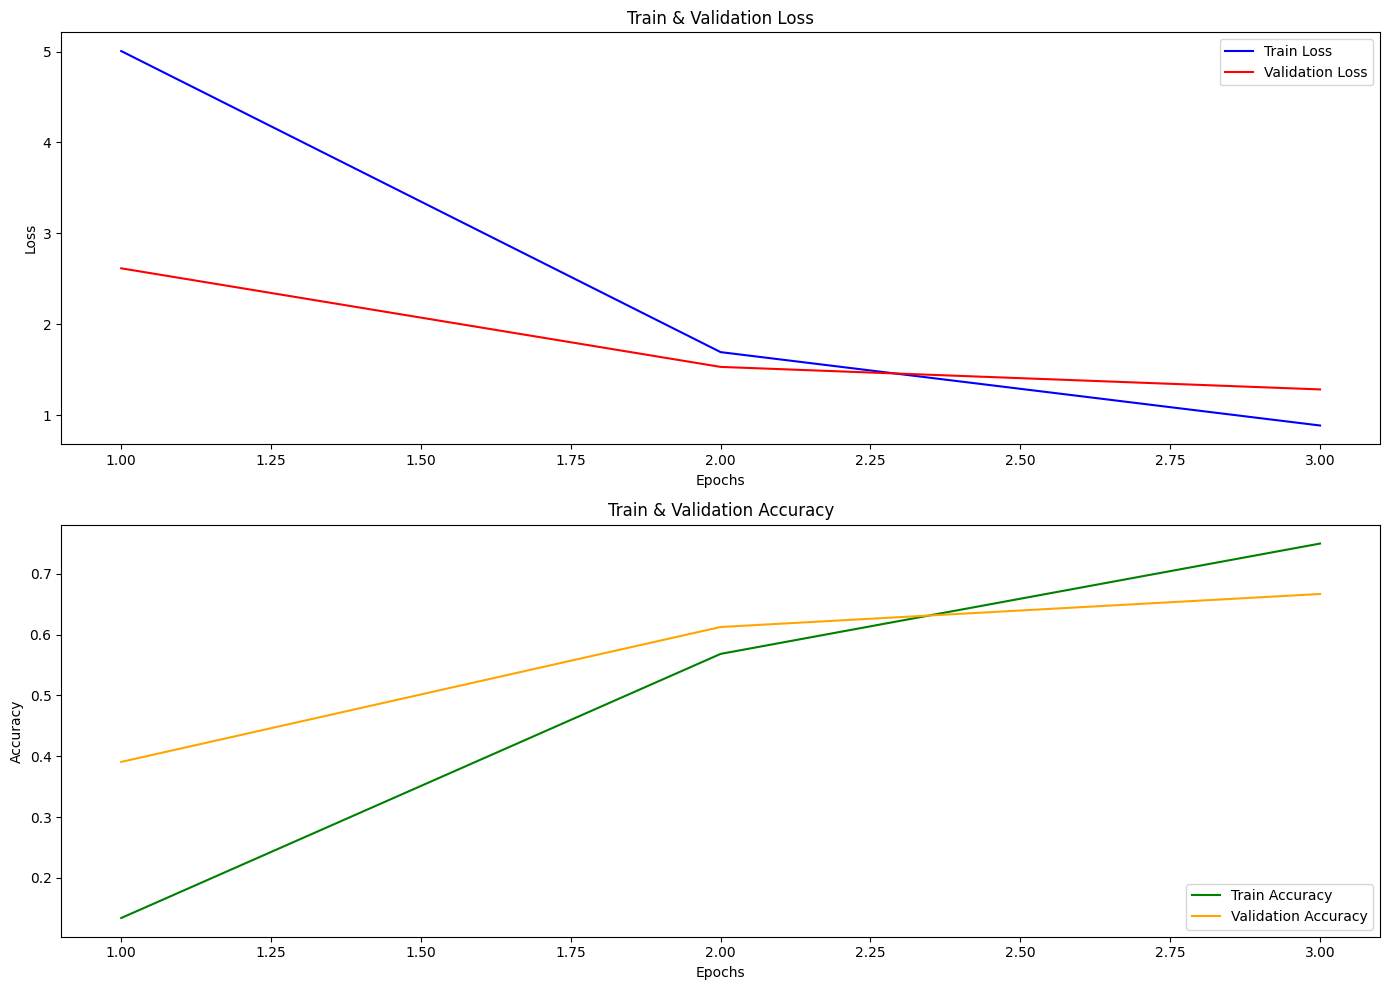

Epoch 4/100


Epoch 4, Train Loss: 0.5601, Train Accuracy: 0.8347
Epoch 4, Validation Loss: 1.2643, Validation Accuracy: 0.6995

Save 3epoch result. Loss = 1.2643
Lowest loss updated to 1.2643. Early stop counter reset to 0.


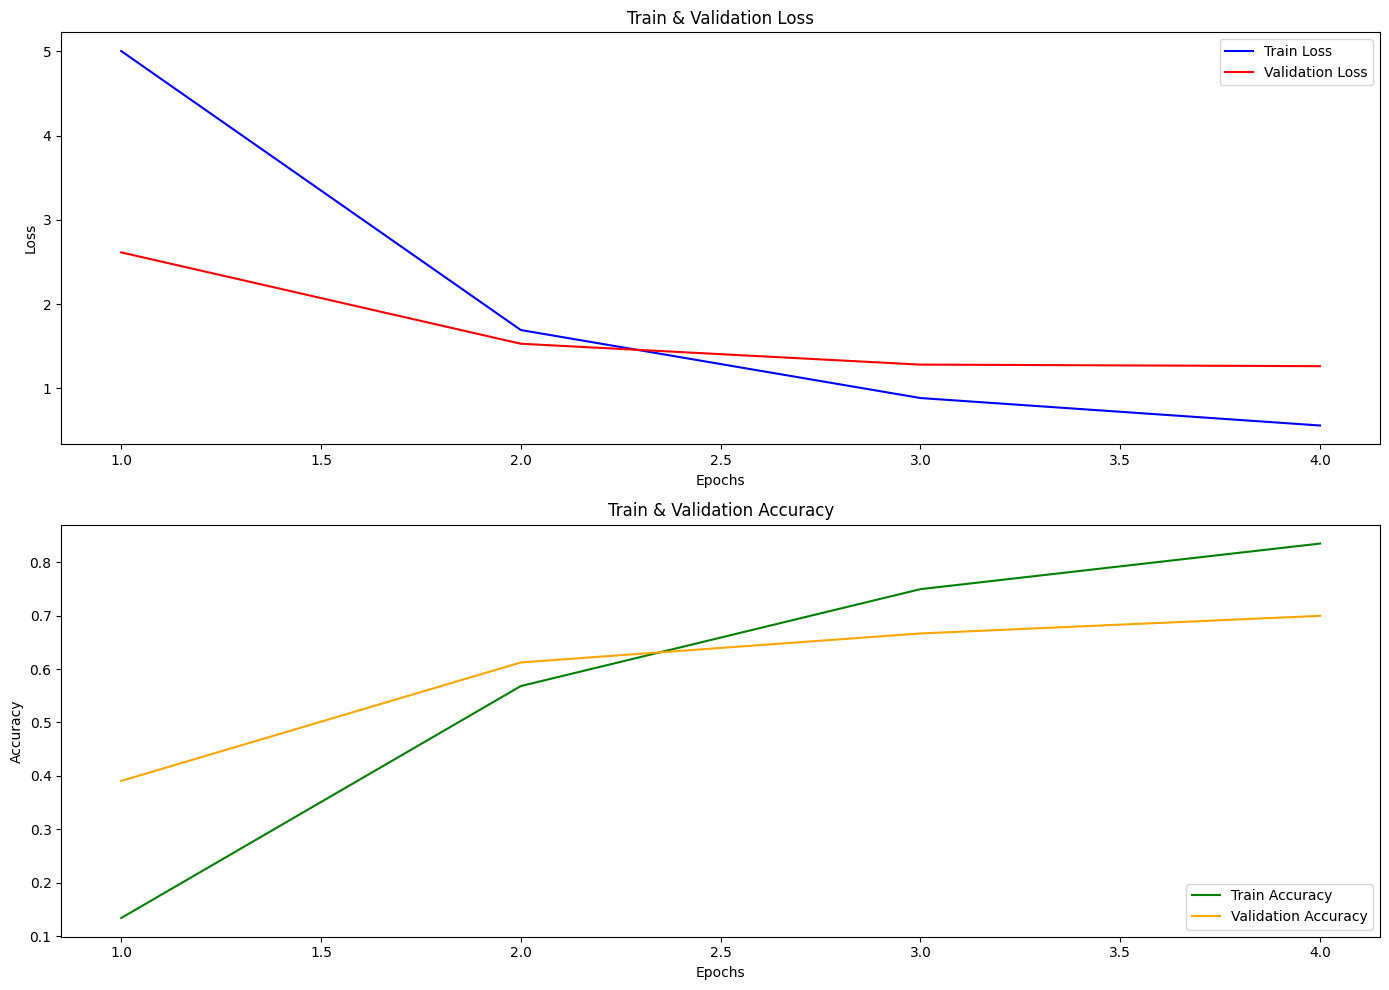

Epoch 5/100


Epoch 5, Train Loss: 0.3943, Train Accuracy: 0.8758
Epoch 5, Validation Loss: 1.2615, Validation Accuracy: 0.7098

Save 4epoch result. Loss = 1.2615
Lowest loss updated to 1.2615. Early stop counter reset to 0.


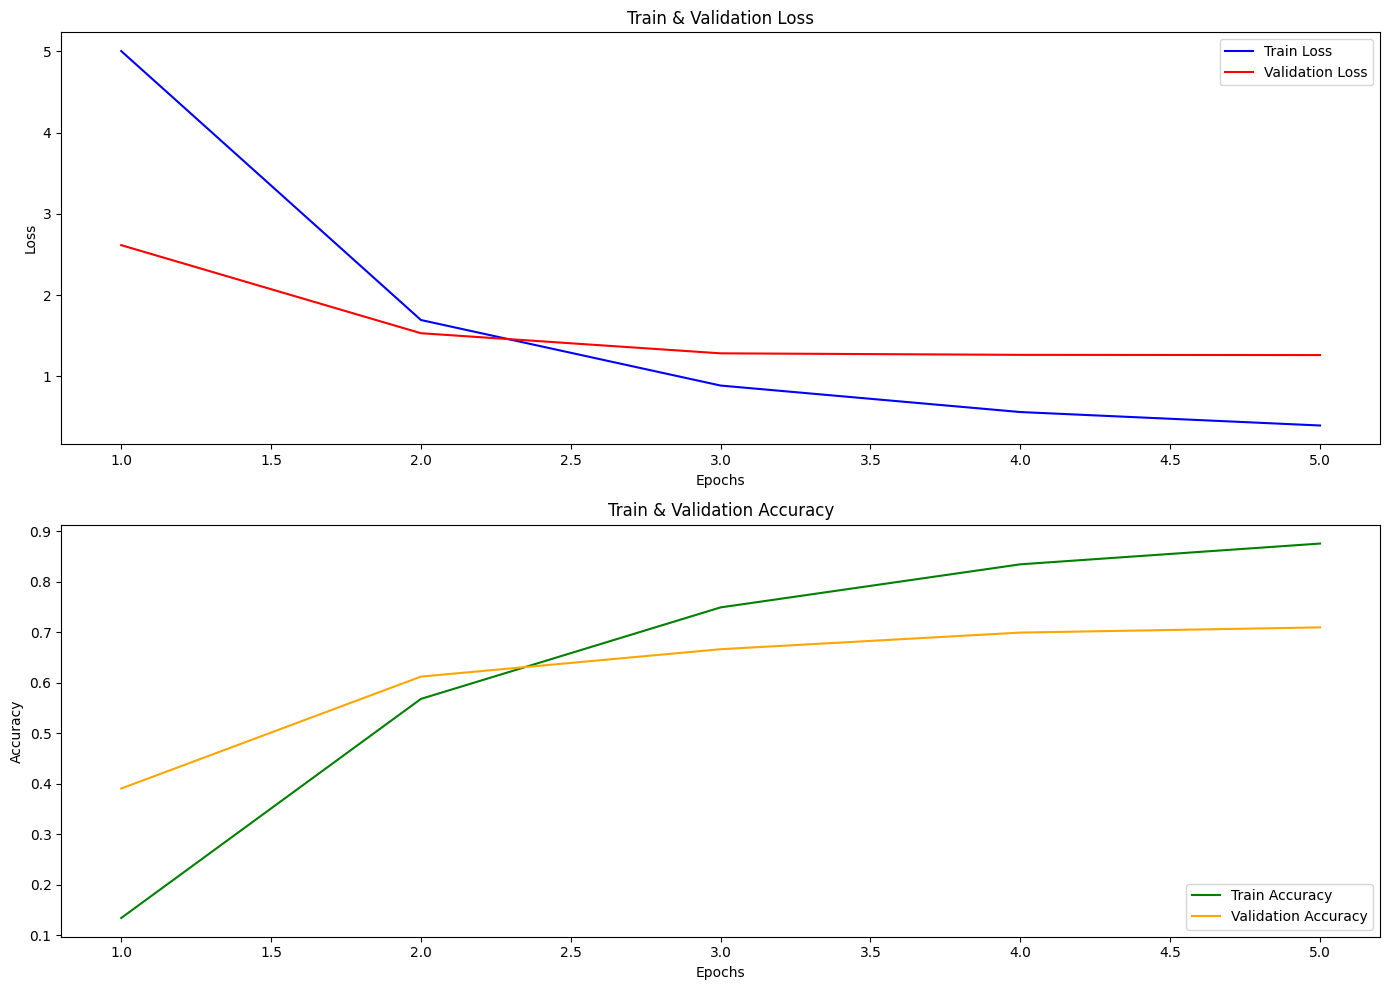

Epoch 6/100


Epoch 6, Train Loss: 0.2945, Train Accuracy: 0.9103
Epoch 6, Validation Loss: 1.1642, Validation Accuracy: 0.7295

Save 5epoch result. Loss = 1.1642
Lowest loss updated to 1.1642. Early stop counter reset to 0.


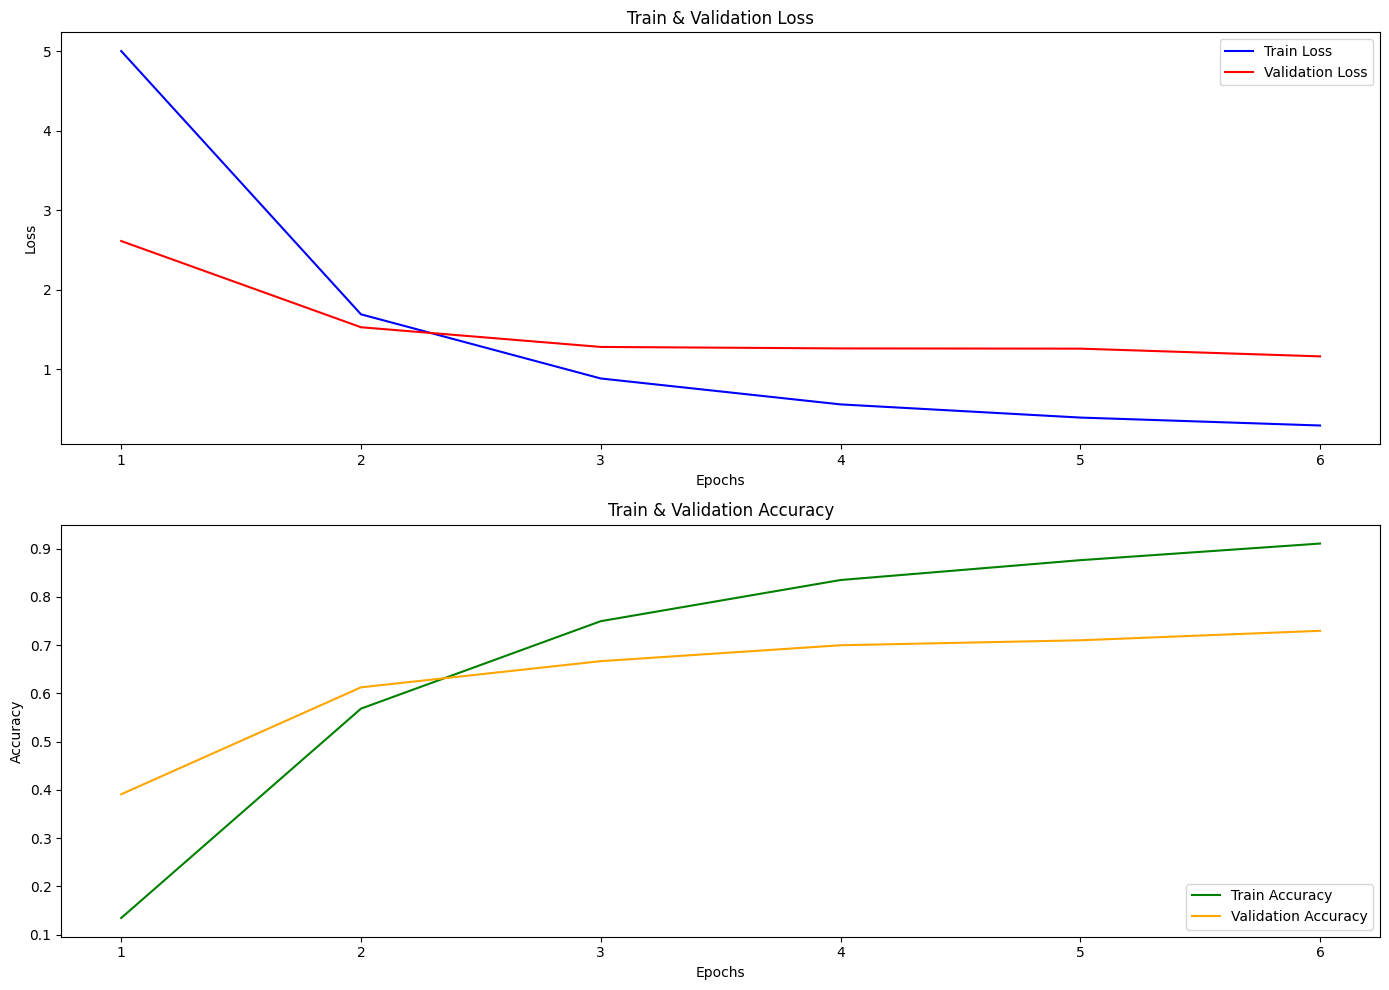

Epoch 7/100


Epoch 7, Train Loss: 0.2208, Train Accuracy: 0.9322
Epoch 7, Validation Loss: 1.2593, Validation Accuracy: 0.7288



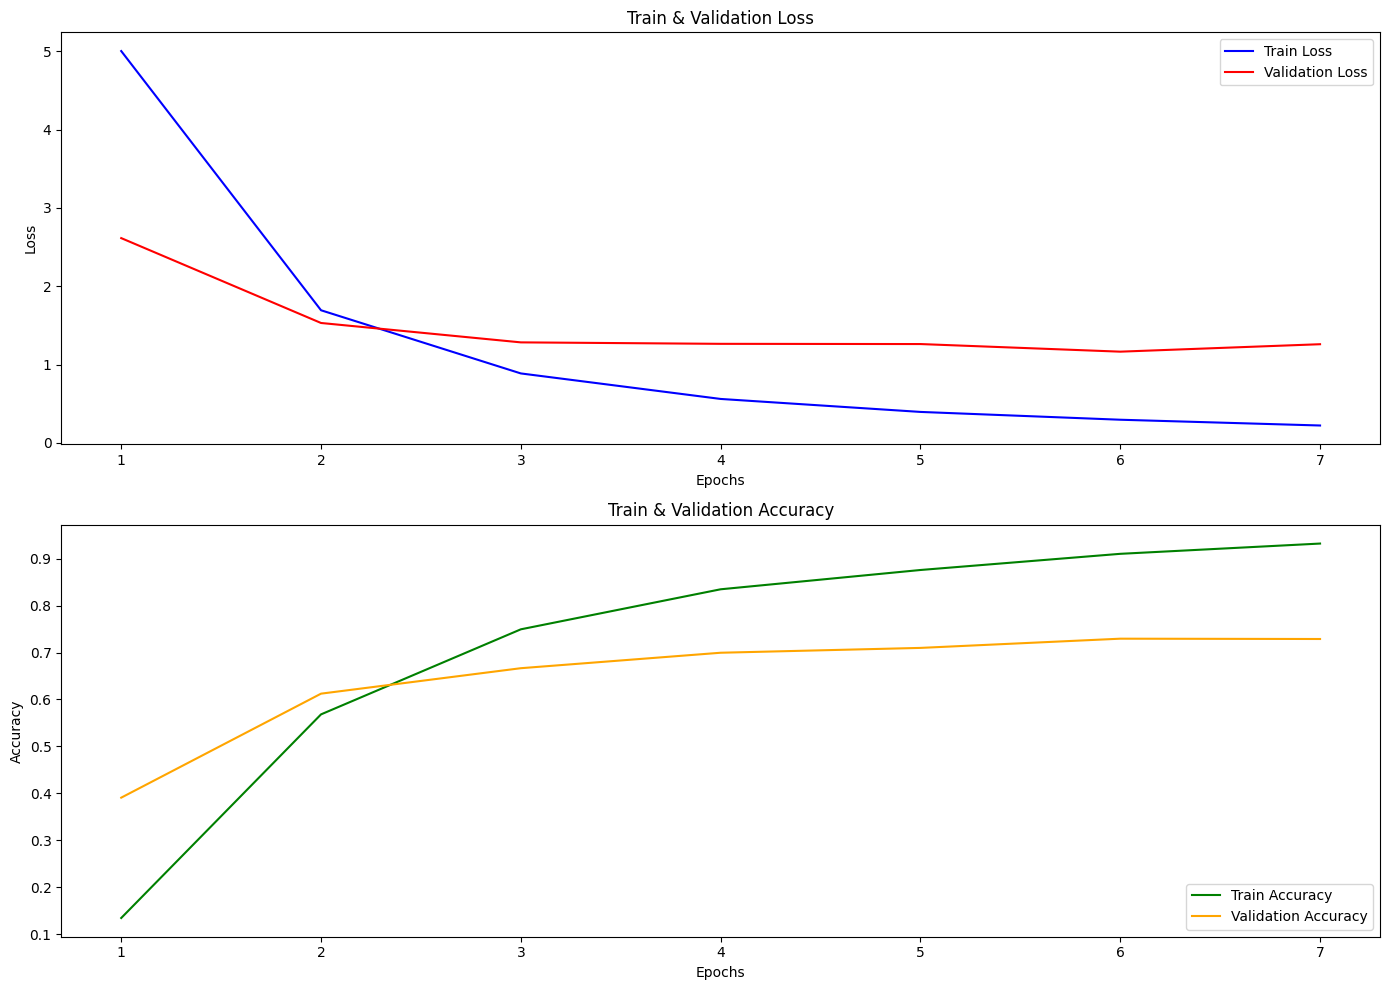

Epoch 8/100


Epoch 8, Train Loss: 0.1788, Train Accuracy: 0.9451
Epoch 8, Validation Loss: 1.2006, Validation Accuracy: 0.7311



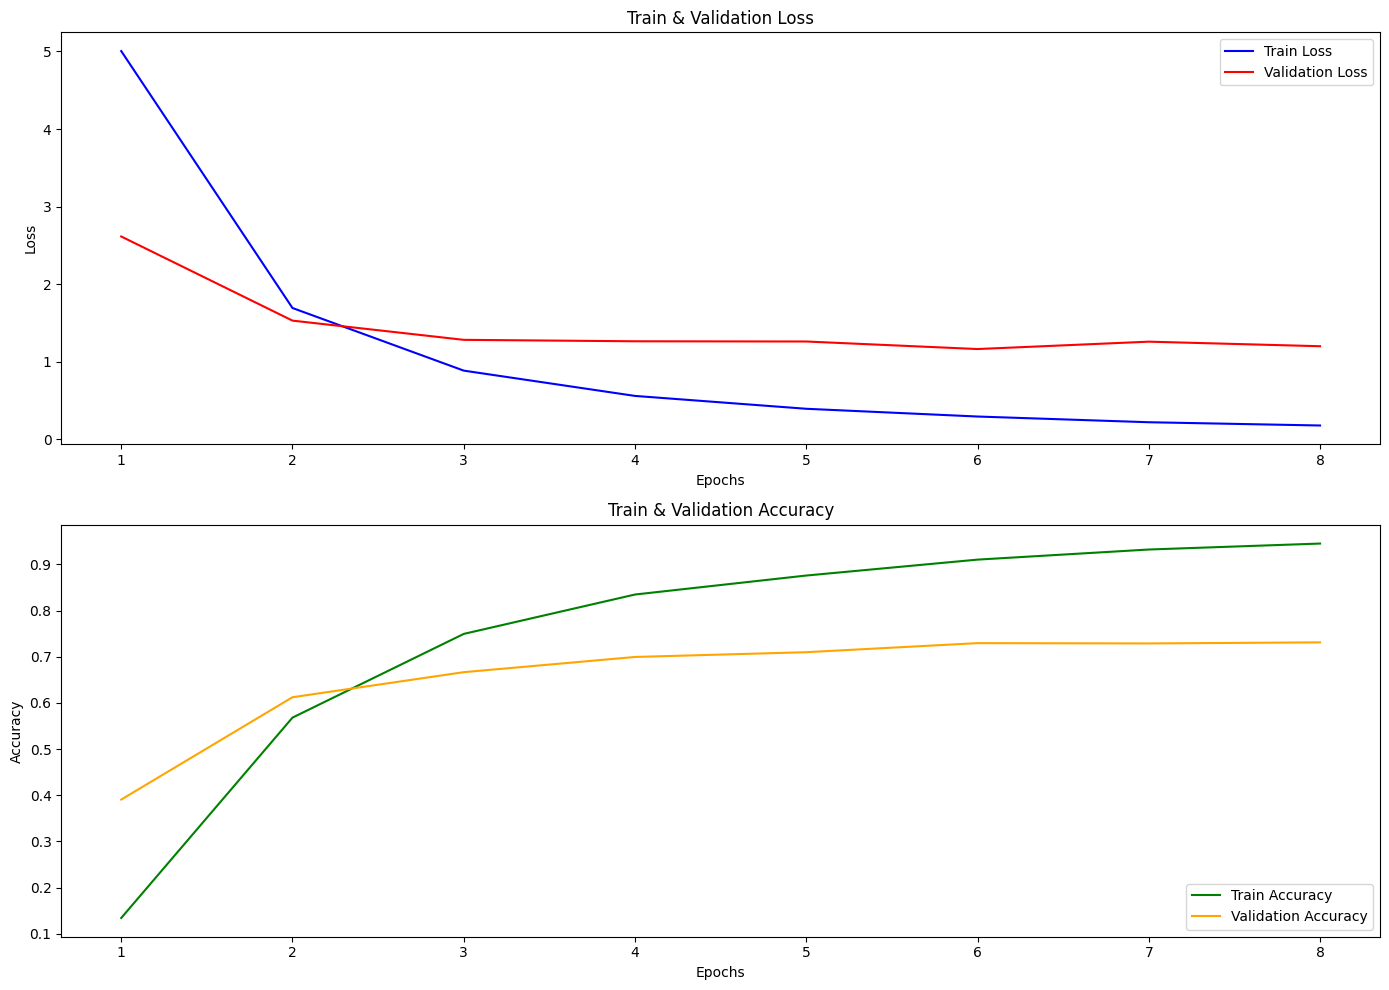

Epoch 9/100


Epoch 9, Train Loss: 0.1611, Train Accuracy: 0.9496
Epoch 9, Validation Loss: 1.2955, Validation Accuracy: 0.7354



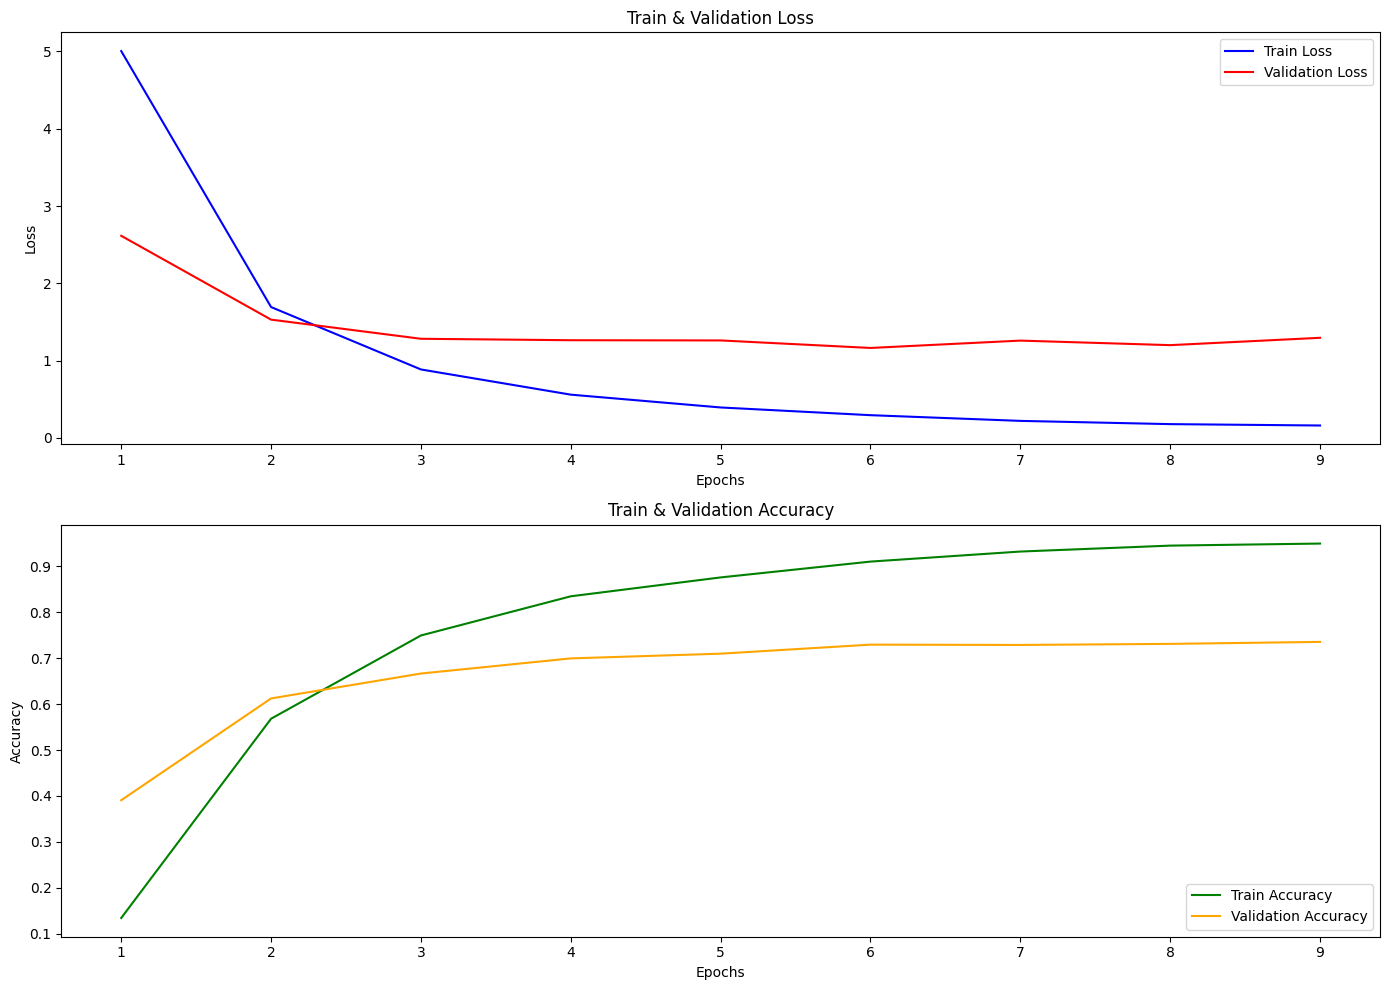

Epoch 10/100


Epoch 10, Train Loss: 0.1394, Train Accuracy: 0.9560
Epoch 10, Validation Loss: 1.2989, Validation Accuracy: 0.7314



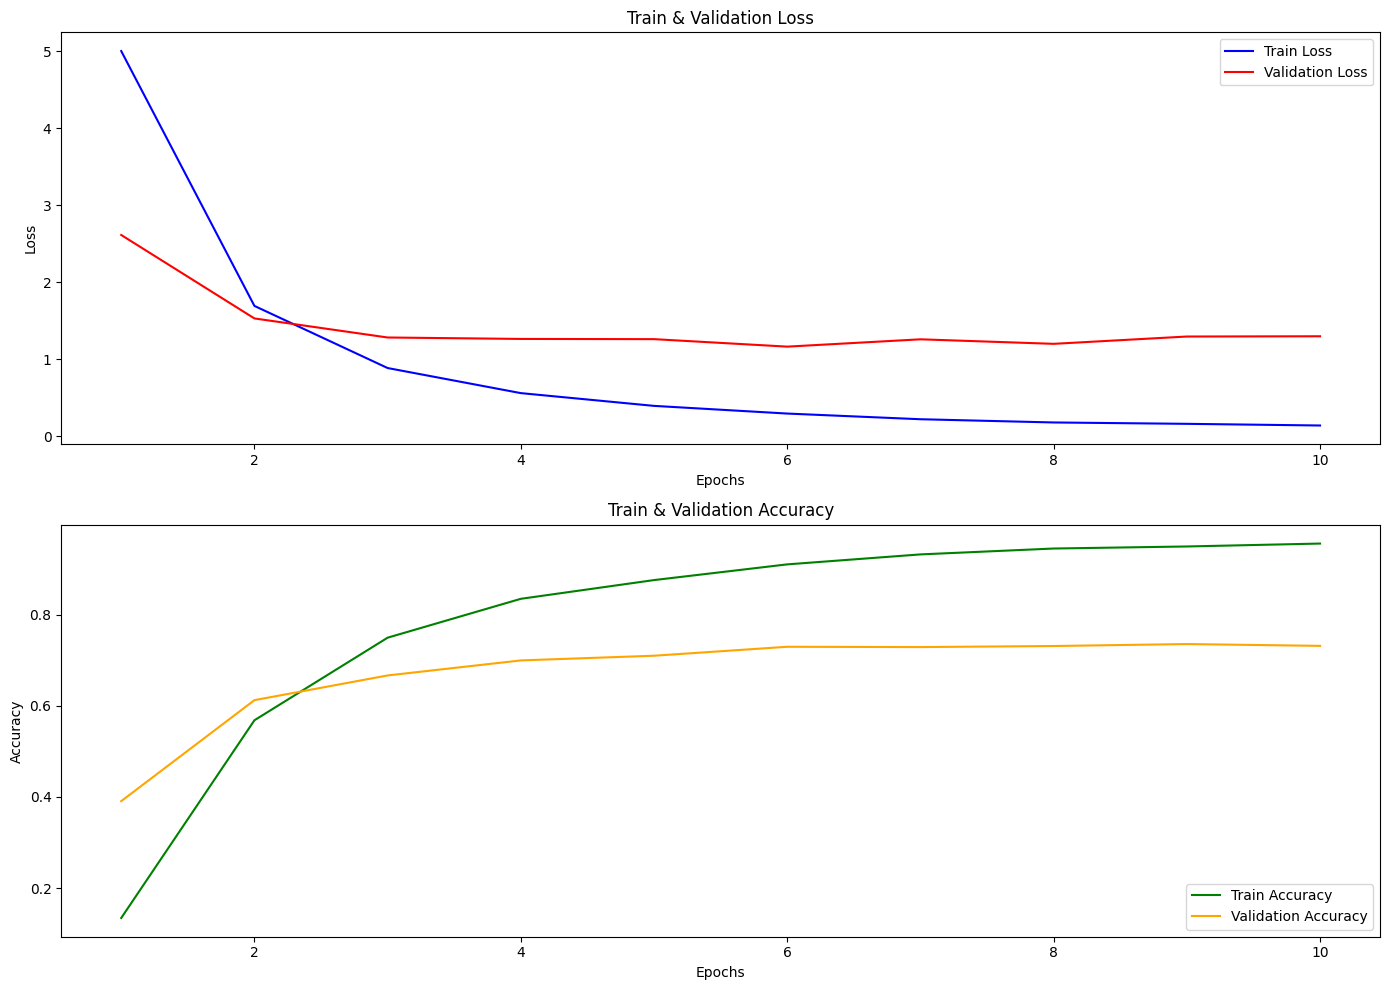

Epoch 11/100


Epoch 11, Train Loss: 0.1162, Train Accuracy: 0.9655
Epoch 11, Validation Loss: 1.3393, Validation Accuracy: 0.7328

Early stopping at epoch 11.


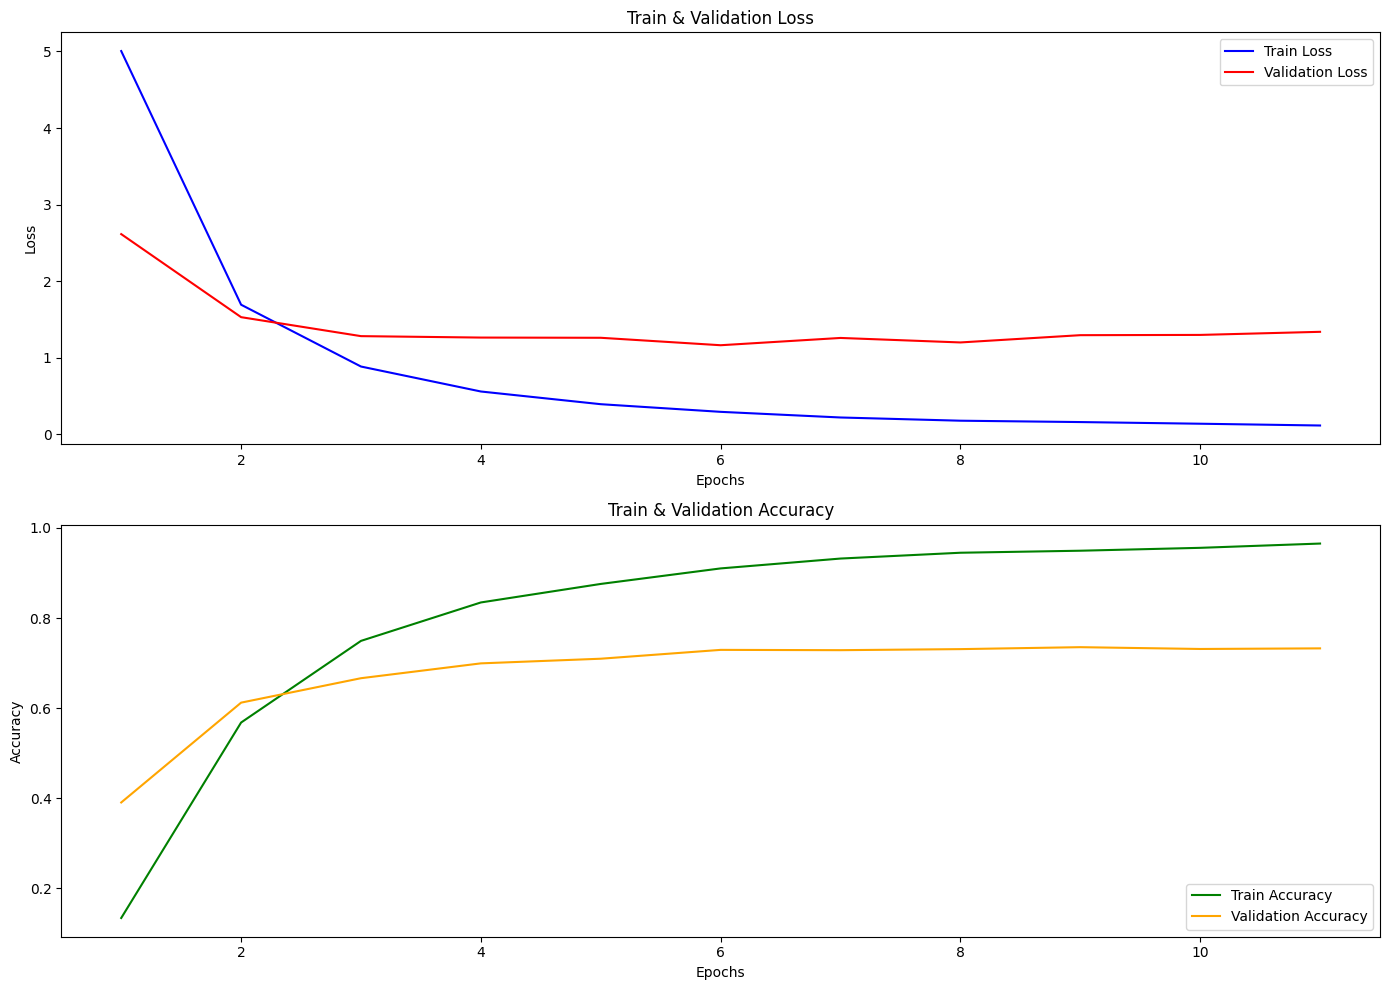

In [12]:
# 모델 학습.
trainer.train()

# Inference

In [13]:
# 모델 추론을 위한 함수
def inference(
    model: nn.Module, 
    device: torch.device, 
    test_loader: DataLoader
):
    # 모델을 평가 모드로 설정
    model.to(device)
    model.eval()
    
    predictions = []
    with torch.no_grad():  # Gradient 계산을 비활성화
        for images in tqdm(test_loader):
            # 데이터를 같은 장치로 이동
            images = images.to(device)
            
            # 모델을 통해 예측 수행
            logits = model(images)
            logits = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            
            # 예측 결과 저장
            predictions.extend(preds.cpu().detach().numpy())  # 결과를 CPU로 옮기고 리스트에 추가
    
    return predictions

In [14]:
# 추론 데이터의 경로와 정보를 가진 파일의 경로를 설정.
testdata_dir = "./data/test"
testdata_info_file = "./data/test.csv"
save_result_path = "./train_result"

In [15]:
# 추론 데이터의 class, image path, target에 대한 정보가 들어있는 csv파일을 읽기.
test_info = pd.read_csv(testdata_info_file)

# 총 class 수.
num_classes = 500

In [16]:
# 추론에 사용할 Transform을 선언.
transform_selector = TransformSelector(
    transform_type = "torchvision"
)
test_transform = transform_selector.get_transform(is_train=False)

# 추론에 사용할 Dataset을 선언.
test_dataset = CustomDataset(
    root_dir=testdata_dir,
    info_df=test_info,
    transform=test_transform,
    is_inference=True
)

# 추론에 사용할 DataLoader를 선언.
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    drop_last=False
)

In [17]:
# 추론에 사용할 장비를 선택.
# torch라이브러리에서 gpu를 인식할 경우, cuda로 설정.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 추론에 사용할 Model을 선언.
model_selector = ModelSelector(
    model_type='timm', 
    num_classes=num_classes,
    model_name='resnet101', 
    pretrained=False
)
model = model_selector.get_model()


In [18]:
# best epoch 모델을 불러오기.
model.load_state_dict(
    torch.load(
        os.path.join(save_result_path, "best_model.pt"),
        map_location='cpu'
    )
)

<All keys matched successfully>

In [19]:
# predictions를 CSV에 저장할 때 형식을 맞춰서 저장
# 테스트 함수 호출
predictions = inference(
    model=model, 
    device=device, 
    test_loader=test_loader
)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [01:45<00:00,  1.50it/s]


In [20]:
# 모든 클래스에 대한 예측 결과를 하나의 문자열로 합침
test_info['target'] = predictions
test_info = test_info.reset_index().rename(columns={"index": "ID"})
test_info

,ID,image_path,target
0,0,0.JPEG,115
1,1,1.JPEG,115
2,2,2.JPEG,12
3,3,3.JPEG,331
4,4,4.JPEG,331
...,...,...,...
10009,10009,10009.JPEG,344
10010,10010,10010.JPEG,12
10011,10011,10011.JPEG,115
10012,10012,10012.JPEG,331


In [21]:
# DataFrame 저장
test_info.to_csv("output101.csv", index=False)